In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
        AveragePooling2D, UpSampling2D, Lambda, Activation, merge, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.applications.vgg19 import VGG19
from keras.optimizers import Adam
from keras.utils import to_categorical
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz
import math

Using TensorFlow backend.


In [2]:
#Open dataset
x_train = bcolz.open('dataset3/x_train.bc')[:]
y_train = bcolz.open('dataset3/y_train.bc')[:]

x_validate = bcolz.open('dataset3/x_validate.bc')[:]
y_validate = bcolz.open('dataset3/y_validate.bc')[:]

output_shape = y_train[0].shape
num_train = y_train.shape[0]
num_validate = y_validate.shape[0]

In [3]:
def get_output(m, ln):
    name = 'block' + str(ln) + '_conv2'
    return m.get_layer(name).output

def mean_squared_error(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

def content_fn(x):
    res = 0
    n = len(layer_weights)
    for i in range(n):
        res += mean_squared_error(x[i]-x[i+n]) * layer_weights[i]
    return res

In [4]:
'''NETWORK #1 - Generative network'''
L = Input(x_train.shape[1:])
sc = 64 #Scale factor

#M0
##Input layer - Downsample L
L_down = AveragePooling2D(padding='same')(L)
n = int(math.log(sc,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down) 
#Intermediate layer
x = Conv2D(1024, (3,3), padding='same')(L_down)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M1
#Upsample F0
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L)   #Downsample L
n = int(math.log(sc/2,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)    
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M2
#Upsample F1
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/4,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(1024, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M3
#Upsample F2
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/8,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M4
#Upsample F3
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/16,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(512, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M5
#Upsample F4
x = UpSampling2D()(x)
#Input layer
L_down = AveragePooling2D(padding='same')(L) #Downsample L
n = int(math.log(sc/32,2) - 1)
for i in range(n):
    L_down = AveragePooling2D(padding='same')(L_down)
x = Concatenate()([L_down, x]) #Concatenate L_down and Fx_up
#Intermediate layer
x = Conv2D(128, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer
x = Conv2D(128, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

#M6
#Upsample F5
x = UpSampling2D()(x)
#Input layer
x = Concatenate()([L, x]) #Concatenate L and Fx_up
#Intermediate layer
x = Conv2D(32, (3,3), padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)
#Output layer - Apply 1x1 conv to F6
x = Conv2D(3, (1,1), padding='same')(x)
#x = Activation('tanh')(x)

#Scale output so we get 0 to 255
#n1_out = Lambda(lambda x: (x+1)*127.5)(x)
n1_out = Lambda(lambda x: (x+1)/2.0*255.0)(x)

In [5]:
'''NETWORK #2 - VGG'''
#We want to use VGG so that we know the difference in activation between
#high-res image and output of the low-res image
#High-res -> VGG -> high-res activation
#Low-res -> trainableCNN -> VGG -> generated image activation

#Note that there are 2 inputs for VGG network:
#   1. Output of the low-res image from trainable network
#   2. High-res image

'''VGG input preprocessing as stated in the paper'''
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess_vgg = lambda x: (x - vgg_mean)[:, :, :, ::-1]

vgg_inp = Input(output_shape)
vgg = VGG19(include_top=False,weights='imagenet',
            input_tensor=Lambda(preprocess_vgg)(vgg_inp))

#Make sure vgg layers are not trainable
for layer in vgg.layers: 
    layer.trainable=False

In [6]:
#Define model that will grab the activations from 5 conv layers
vgg_content = Model(vgg_inp, [get_output(vgg, o) for o in [1,2,3,4,5]])

#vgg1 = for the reference image
vgg1 = vgg_content(vgg_inp)

#vgg2 = for the generated image
vgg2 = vgg_content(n1_out)

In [7]:
#Define weights: how much each conv layer output to effect the model
layer_weights=[0.5, 0.25, 0.125, 0.0625, 0.0625]

In [8]:
#Define the model that actually minimizes the loss
model = Model([L, vgg_inp], Lambda(content_fn)(vgg1+vgg2))

#We want the output of our model (loss) to be zeros
train_target = np.zeros((num_train, 1))
val_target = np.zeros((num_validate, 1))

model.compile(Adam(0.0001), loss='mean_squared_error', metrics=['accuracy'])

In [ ]:
model.optimizer = Adam(0.0001)
model.fit([x_train, y_train], train_target, 
          batch_size=3, epochs=250, 
          validation_data=([x_validate, y_validate],val_target))

In [17]:
trained_model = Model(L, n1_out)

In [18]:
#Open test set
x_test = bcolz.open('dataset3/x_test.bc')[:]
y_test = bcolz.open('dataset3/y_test.bc')[:]
num_test = y_test.shape[0]

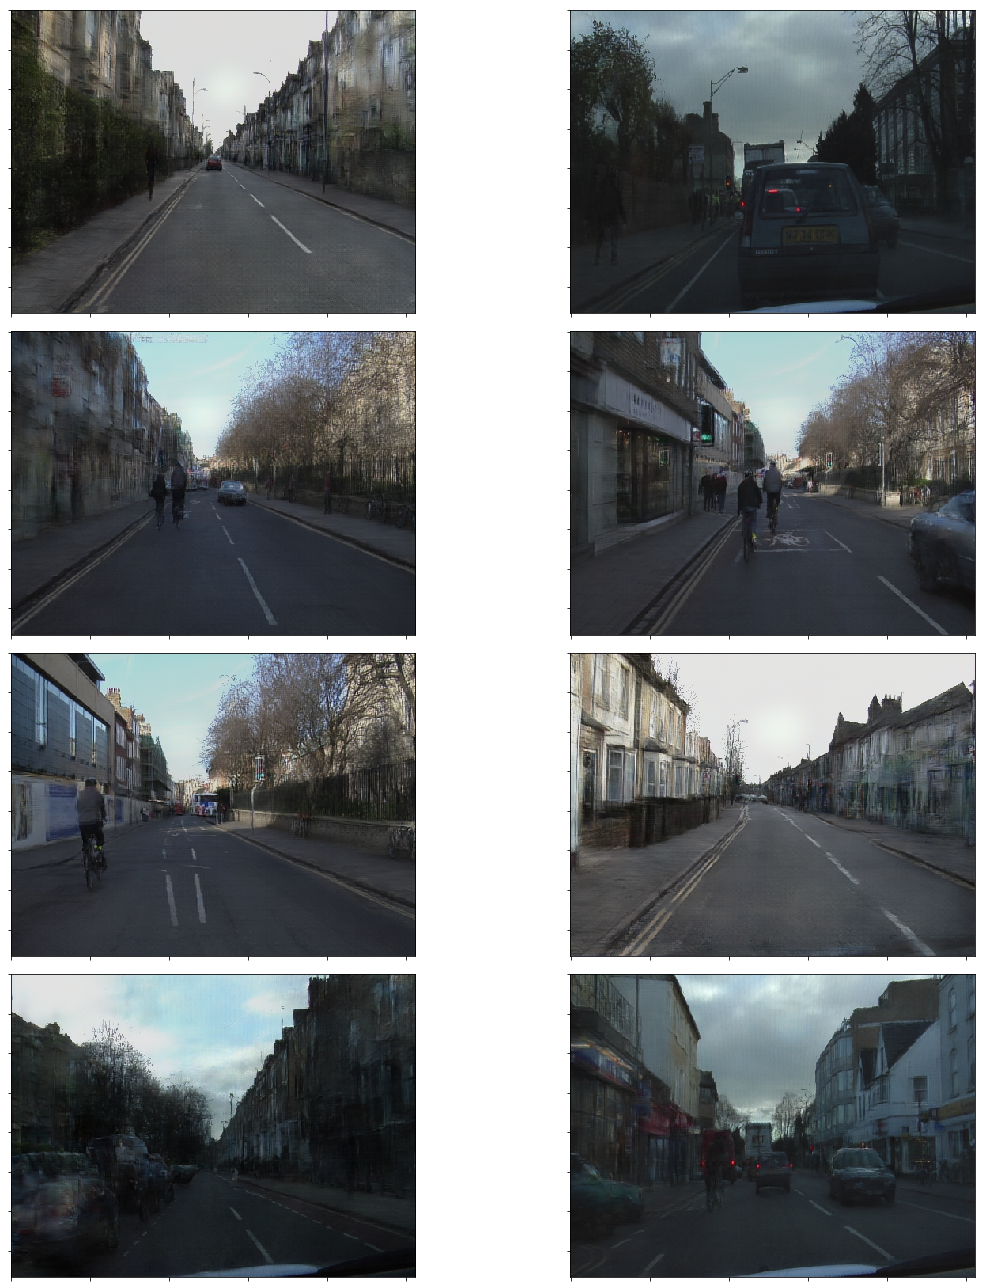

In [26]:
num_pred = 8
fig,axis = plt.subplots(nrows=4, ncols=2, figsize=(18,18))
for i in range(4):
    random_index = np.random.randint(0,76)
    img = np.expand_dims(x_test[random_index],axis=0)
    predictions = trained_model.predict(img)
    #axis[i,0].imshow(predictions[0]/255.0)
    axis[i,0].imshow((predictions[0]-np.amin(predictions[0]))/
                     (np.amax(predictions[0])-np.amin(predictions[0]))) 
    axis[i,0].set_yticklabels([])
    axis[i,0].set_xticklabels([])
    
    random_index = np.random.randint(0,76)
    img = np.expand_dims(x_test[random_index],axis=0)
    predictions = trained_model.predict(img)
    #axis[i,1].imshow(predictions[0]/255.0)
    axis[i,1].imshow((predictions[0]-np.amin(predictions[0]))/
                     (np.amax(predictions[0])-np.amin(predictions[0])))
    axis[i,1].set_yticklabels([])
    axis[i,1].set_xticklabels([])

plt.tight_layout()
plt.show()

In [24]:
trained_model.save('crn_model_batchnorm.h5')
trained_model.save_weights('crn_weights_batchnorm.h5')